### 01 Sankey plot for Smirdin's collection dynamics

This notebooks shows the way the data was prepared for creating the sankey plot (`riverplot` pck).

In [1]:
library(tidyverse)
library(riverplot)

library(wesanderson)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## path below needs to be changed

In [16]:
#### load & prepare data ####

# change this rel. PATH!!!
smird <- read.csv("../../github_main/data/biblio_poetry_1830_1850.csv", na.strings = "NA") 

# select only id and Smirding's library-related columns
smird <- smird %>% 
  select(id, year, poetry_prose, book_type, genre, 
         smirdin_1832, olhin_46, krashen_52, kymmel_89, CZ_SLK) %>% 
  mutate_all(~na_if(., "")) %>% 
  mutate_at(vars(smirdin_1832:CZ_SLK), ~na_if(., "нет"))
  
head(smird)

,id,year,poetry_prose,book_type,genre,smirdin_1832,olhin_46,krashen_52,kymmel_89,CZ_SLK
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>
1,1,1834,v,sep,nar,NA,5394,NA,NA,NA
2,2,1834,v,sep,lyr,NA,NA,NA,NA,NA
3,4,1834,v,sep,lyr,NA,NA,NA,NA,NA
4,5,1834,v,col,lyr,NA,NA,6119,1240,да
5,6,1834,v,sep,nar,NA,NA,15362,567,да
6,7,1834,v,col,lyr,NA,NA,15196,569,NA


In [17]:
# count connections between each collections
smird_wide <- smird %>%
  mutate(book_id = paste(id, year, poetry_prose, book_type, genre, sep = "_")) %>%
  select(book_id, smirdin_1832, olhin_46, krashen_52, kymmel_89, CZ_SLK) %>% 
  mutate(sm_ol = ifelse((!is.na(smirdin_1832) & !is.na(olhin_46)), 1, 0),
         sm_kr = ifelse((!is.na(smirdin_1832) & !is.na(krashen_52)), 1, 0),
         sm_kym = ifelse((!is.na(smirdin_1832) & !is.na(kymmel_89)), 1, 0),
         sm_cz = ifelse((!is.na(smirdin_1832) & !is.na(CZ_SLK)), 1, 0),

         ol_kr = ifelse(!is.na(olhin_46) & !is.na(krashen_52), 1, 0),
         ol_kym = ifelse(!is.na(olhin_46) & !is.na(kymmel_89), 1, 0),
         ol_cz = ifelse(!is.na(olhin_46) & !is.na(CZ_SLK), 1, 0),
         
         kr_kym = ifelse(!is.na(krashen_52) & !is.na(kymmel_89), 1, 0),
         kr_cz = ifelse(!is.na(krashen_52) & !is.na(CZ_SLK), 1, 0),
         
         kym_cz = ifelse(!is.na(kymmel_89) & !is.na(CZ_SLK), 1, 0)) %>% 
  select(book_id, sm_ol:kym_cz) 

head(smird_wide)

,book_id,sm_ol,sm_kr,sm_kym,sm_cz,ol_kr,ol_kym,ol_cz,kr_kym,kr_cz,kym_cz
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1_1834_v_sep_nar,0,0,0,0,0,0,0,0,0,0
2,2_1834_v_sep_lyr,0,0,0,0,0,0,0,0,0,0
3,4_1834_v_sep_lyr,0,0,0,0,0,0,0,0,0,0
4,5_1834_v_col_lyr,0,0,0,0,0,0,0,1,1,1
5,6_1834_v_sep_nar,0,0,0,0,0,0,0,1,1,1
6,7_1834_v_col_lyr,0,0,0,0,0,0,0,1,0,0


#### Prepare nodes and edges for sankey plot

In [19]:
# pivot table to edges & count frequency of each edge
edges <- smird_wide %>% 
  pivot_longer(!book_id, names_to = "direction", values_to = "value") %>% 
  group_by(direction) %>% 
  summarise(Value = sum(value)) %>% 
  filter(Value != 0) %>% 
  separate(col = direction, into = c("N1", "N2")) %>% 
  mutate(ID = paste0("E.", N1, "_", N2)) %>% 
  select(ID, N1, N2, Value) %>% 
  data.frame


nodes <- data.frame(ID = unique(c(edges$N1, edges$N2)),
                    # x-axis positions for each collection (chronological)
                    x = c(5,8,2,1,10))

edges

ID,N1,N2,Value
<chr>,<chr>,<chr>,<dbl>
E.kr_cz,kr,cz,117
E.kr_kym,kr,kym,206
E.kym_cz,kym,cz,101
E.ol_cz,ol,cz,84
E.ol_kr,ol,kr,185
E.ol_kym,ol,kym,136
E.sm_cz,sm,cz,37
E.sm_kr,sm,kr,4
E.sm_kym,sm,kym,52


In [20]:
nodes

ID,x
<chr>,<dbl>
kr,5
kym,8
ol,2
sm,1
cz,10


In [21]:
# total number of books in each collection
smird %>% 
  select(c(id, smirdin_1832:CZ_SLK)) %>% 
  mutate(across(everything(), as.character)) %>% 
  pivot_longer(!id, names_to = "libs", values_to = "value") %>% 
  mutate(value = ifelse(!is.na(value), 1, 0)) %>% 
  group_by(libs) %>% 
  summarise(total = sum(value))

libs,total
<chr>,<dbl>
CZ_SLK,197
krashen_52,347
kymmel_89,312
olhin_46,425
smirdin_1832,113


#### Sankeyplot 

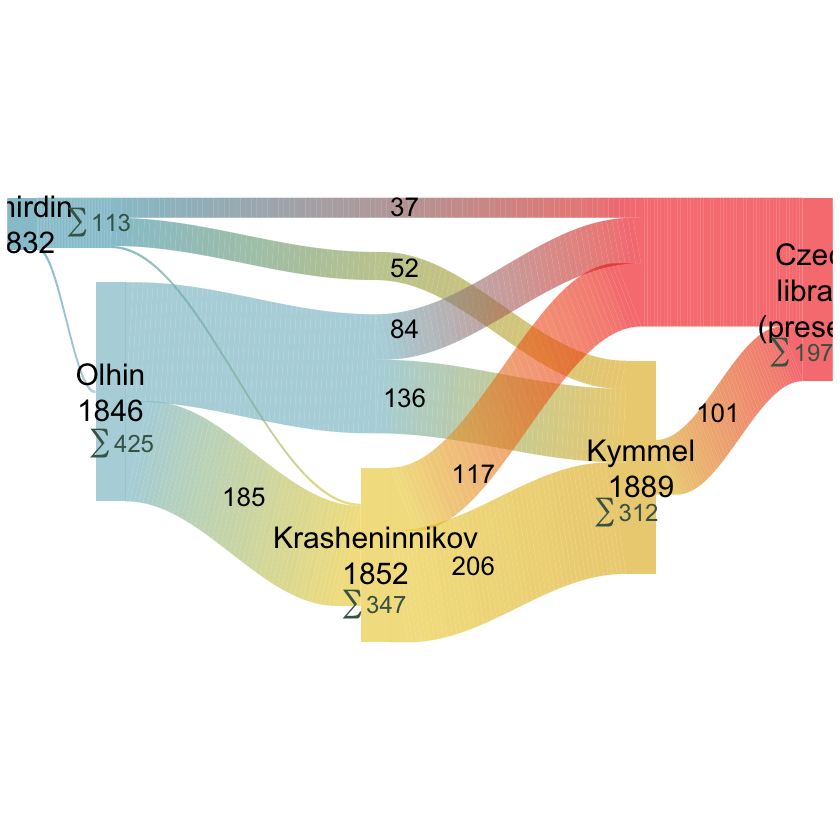

In [22]:
r <- makeRiver(nodes = nodes, edges = edges,
               node_labels = c(
                 "Krasheninnikov\n1852",
                 "Kymmel\n1889", 
                 "Olhin\n1846",
                 "Smirdin\n1832",
                 "Czech\nlibrary\n(present)"
               ),
               node_styles = list(
                 sm = list(col = "#3B9AB295"),
                 ol = list(col = "#78B7C595"),
                 kr = list(col = "#EBCC2A95"),
                 kym = list(col = "#E1AF0095"),
                 cz = list(col = "#F21A0095")
               ))

par(mar=rep(0.3,4))
par(lty = 0)


plot(r, 
     plot_area = c(1, 0.7),
     srt = 0, 
     textcex = 1.5)

# additional labels
text(0.48, 0.78, "37", cex = 1.3) # sm to cz
text(0.48, 0.70, "52", cex = 1.3) # sm to kym
text(0.48, 0.62, "84", cex = 1.3) # ol to cz
text(0.48, 0.53, "136", cex = 1.3) # ol to kym
text(0.27, 0.40, "185", cex = 1.3) # ol to kr
text(0.57, 0.43, "117", cex = 1.3) # kr to cz
text(0.57, 0.31, "206", cex = 1.3) # kr to kym
text(0.89, 0.51, "101", cex = 1.3) # kym to cz

  
#wes_palette("Chevalier1")[1]
text(0.08, 0.76, expression(sum(113)), cex = 1.2, col = "#446455") # sm
text(0.11, 0.47, expression(sum(425)), cex = 1.2, col = "#446455") # ol
text(0.44, 0.26, expression(sum(347)), cex = 1.2, col = "#446455") # kr
text(0.77, 0.38, expression(sum(312)), cex = 1.2, col = "#446455") # kym
text(0.999, 0.59, expression(sum(197)), cex = 1.2, col = "#446455") # cz
